In [14]:
import pandas as pd
import numpy as np
import catboost
import plotly.express as px

# Read Data

In [15]:
df_credits = pd.read_csv('../data/User Credits Student Access.csv', encoding='utf-8')
df_atlas = pd.read_csv('../data/Atlas Cechu Student Access.csv', encoding='utf-8')
df_payments = pd.read_csv('../data/Payments Student Access.csv', encoding='utf-8')

# Negative Values investigation & Chekcing other things

In [16]:
df_c_negative = df_credits[df_credits['credits']<0]
df_credits[df_credits.user.isin(df_c_negative.user) == True]

# IDK what I'm doing with payments
df_payments[df_payments.user.isin(df_c_negative.user)==True].sort_values(['user','created_at'])
df_payments.state.unique()
df_payments[df_payments.user=='STUD54678']
df_credits[df_credits.user=='STUD54678']

,user,credits,is_active,is_verified,is_locked,wage
89906,STUD54678,789,1,1,0,Peníze


In [17]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30087 entries, 0 to 30086
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          30086 non-null  float64
 1   created_at  30087 non-null  object 
 2   changed_at  30087 non-null  object 
 3   user        27652 non-null  object 
 4   batch       27502 non-null  object 
 5   credits     30086 non-null  float64
 6   state       30086 non-null  object 
 7   type        30086 non-null  object 
dtypes: float64(2), object(6)
memory usage: 1.8+ MB


# Data Cleaning

In [18]:
df_credits_cleaned = df_credits[df_credits['credits']>0]
df_payments_cleaned = df_payments[df_payments['id'].notna()]

# What is core table for merge? - Payments // Can't I just use inner join? Therefore I dont' have to work with nul values - I don't want them in model anyway

In [19]:
#I have an assumption that all users should be in Atlas Cechu. However, after cheking my assumption it tourns out not to be true. 

# Convert the boolean series to a DataFrame with a column name
atlas_in_credits = df_credits_cleaned.user.isin(df_atlas.user_id).rename('User in Atlas')
atlas_in_payments = df_payments_cleaned.user.isin(df_atlas.user_id)

# Plotting
fig_ac = px.bar(atlas_in_credits.value_counts(), title='How many users from Atlas Cechu are in the credits table', labels={'index': 'User in Atlas (True/False)', 'value': 'Count'})
fig_ap = px.bar(atlas_in_payments.value_counts(), title='How many users from Atlas Cechu are in the payments table', labels={'index': 'User in Atlas (True/False)', 'value': 'Count'})

fig_ac.show()
fig_ap.show()

In [20]:
df_atlas.user_id.isin(df_credits_cleaned.user).value_counts()

user_id
True     40672
False     2861
Name: count, dtype: int64

In [9]:
df_atlas.user_id.isin(df_payments_cleaned.user).value_counts()

user_id
False    34824
True      8709
Name: count, dtype: int64

Since we want to find out when who pulls what, it makes sense to use the payments table and connect data to it - even though there are users in payments tables that are not in Atlas Cechu

In [21]:
#df_merge_credits = pd.merge(df_payments_cleaned, df_credits_cleaned, how="inner", left_on='user', right_on='user')
#df_merge_credits[df_merge_credits.user=='STUD92308']

"""
I don't find credits table to be interesting - mainly we cannot join them together due to different "time type" -- credits shows the newest version of creadits without historical changes, on the other hand table payments shows history of all transactions
"""

In [50]:
df_merge_full = pd.merge(df_payments_cleaned, df_atlas, how='inner', left_on='user', right_on='user_id')

In [47]:
df_credits # 2025-05-09

,user,credits,is_active,is_verified,is_locked,wage
0,STUD66006,25,1,1,0,Peníze
1,STUD22095,51,1,1,0,Peníze
2,STUD77411,0,1,1,1,Peníze
3,STUD56329,0,1,0,0,NaN
4,STUD23516,30,1,1,0,Peníze
...,...,...,...,...,...,...
89906,STUD54678,789,1,1,0,Peníze
89907,STUD43709,0,0,1,0,NaN
89908,STUD21881,0,0,0,0,NaN
89909,STUD72037,16,1,1,0,Lékaři bez hranic


In [49]:
df_payments

,id,created_at,changed_at,user,batch,credits,state,type
0,30116.0,2025-04-07 10:32:05.073604+00:00,2025-04-07 10:32:05.073633+00:00,STUD83031,NaN,509.0,REQUEST,MONEY
1,30115.0,2025-04-07 10:30:09.304166+00:00,2025-04-07 10:30:09.304196+00:00,STUD356,NaN,538.0,REQUEST,MONEY
2,30114.0,2025-04-07 09:57:04.343935+00:00,2025-04-07 09:57:04.343985+00:00,STUD25955,NaN,542.0,REQUEST,MONEY
3,30113.0,2025-04-07 09:15:39.069868+00:00,2025-04-07 09:15:39.069910+00:00,STUD45618,NaN,501.0,REQUEST,MONEY
4,30112.0,2025-04-07 08:28:47.838506+00:00,2025-04-07 08:28:47.838578+00:00,STUD44458,NaN,504.0,REQUEST,MONEY
...,...,...,...,...,...,...,...,...
30082,34.0,2017-08-11 14:06:49.193910+00:00,2024-01-10 17:31:11.820777+00:00,STUD29324,5,511.0,PAID,MONEY
30083,33.0,2017-08-11 03:05:08.659811+00:00,2024-12-22 01:16:00.780947+00:00,NaN,NaN,536.0,PAID,CHILDHOOD_HOME
30084,32.0,2017-08-10 22:31:33.619685+00:00,2024-01-10 17:31:11.864003+00:00,NaN,NaN,506.0,PAID,TRENDARO
30085,31.0,2017-08-10 21:58:35.586238+00:00,2024-01-10 17:31:11.867765+00:00,STUD92308,NaN,511.0,PAID,MEDICINS_SANS_FRONTIERS


In [48]:
df_atlas

,user_id,all_intro-2022,atlas_vzorek-2023,atlas_vzorek-2024,all_intro-trendaro_panel_all,sex-woman,sex-man,age-15_17,age-18_24,age-25_34,...,check-tv,check-radio,check-household,check-overdraft,check-naramek,isic2_age-21_26,isic2_age-15_20,isic_age-15_17,isic_age-18_22,isic_age-23_26
0,STUD29866,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
1,STUD35256,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,STUD29684,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,STUD11967,0,0,0,1,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
4,STUD57644,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43528,STUD33520,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43529,STUD64071,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43530,STUD82916,1,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43531,STUD63130,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
df_merge_full.rename(columns={'credits_x':'credits_payments', 'credits_y':'credits_credits'})

,id,created_at,changed_at,user,batch,credits_payments,state,type,credits_credits,is_active,...,check-tv,check-radio,check-household,check-overdraft,check-naramek,isic2_age-21_26,isic2_age-15_20,isic_age-15_17,isic_age-18_22,isic_age-23_26
0,30111.0,2025-04-07 08:15:22.413705+00:00,2025-04-07 08:15:22.413748+00:00,STUD57557,NaN,526.0,REQUEST,MONEY,7,1,...,0,0,0,0,0,0,0,0,0,0
1,30106.0,2025-04-07 07:19:29.931848+00:00,2025-04-07 07:19:29.931894+00:00,STUD89495,NaN,501.0,REQUEST,MONEY,17,1,...,0,0,0,0,0,0,0,0,0,0
2,30099.0,2025-04-06 17:33:35.856134+00:00,2025-04-06 17:33:35.856178+00:00,STUD38916,NaN,506.0,REQUEST,MONEY,7,1,...,0,0,0,0,0,0,0,0,0,0
3,30091.0,2025-04-06 11:05:27.702810+00:00,2025-04-06 11:05:27.702850+00:00,STUD1317,NaN,500.0,REQUEST,MONEY,7,1,...,0,0,0,0,0,1,0,0,0,1
4,30088.0,2025-04-06 09:21:34.481241+00:00,2025-04-06 09:21:34.481292+00:00,STUD73522,NaN,506.0,REQUEST,MONEY,7,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26023,36.0,2017-08-11 14:55:18.396493+00:00,2024-01-10 17:31:11.782802+00:00,STUD49275,5,506.0,PAID,MONEY,741,1,...,0,0,0,0,0,0,0,0,0,0
26024,35.0,2017-08-11 14:54:35.456650+00:00,2024-01-10 17:31:11.801715+00:00,STUD53465,5,523.0,PAID,MONEY,127,1,...,0,0,0,0,0,0,0,0,0,0
26025,34.0,2017-08-11 14:06:49.193910+00:00,2024-01-10 17:31:11.820777+00:00,STUD29324,5,511.0,PAID,MONEY,313,1,...,0,0,0,0,0,0,0,0,0,0
26026,31.0,2017-08-10 21:58:35.586238+00:00,2024-01-10 17:31:11.867765+00:00,STUD92308,NaN,511.0,PAID,MEDICINS_SANS_FRONTIERS,295,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_merge_full.to_csv('../data_output/df_merge_full.csv')

# Modeling

In [24]:
import catboost
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

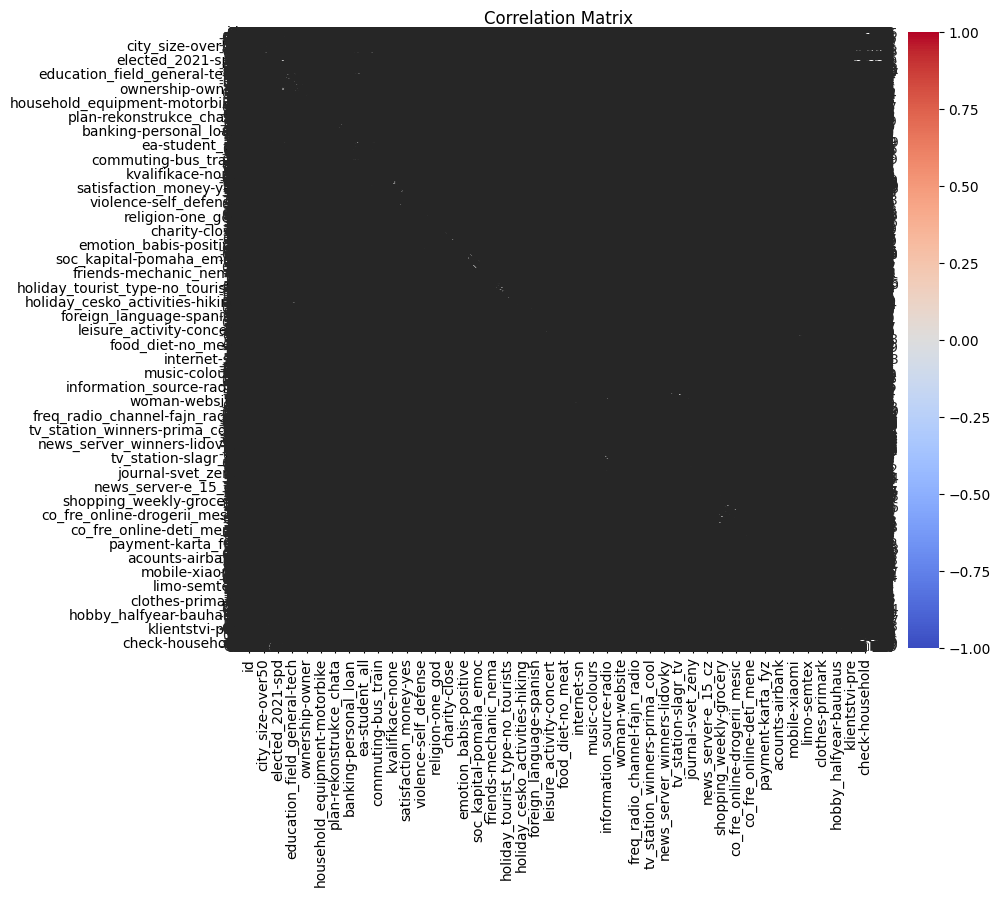

In [13]:
numeric_df = df_merge_full.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# There are fucking over 1000 attributes - no way this could ever work

In [37]:
df_merge_full[['user', 'user_id']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26028 entries, 0 to 26027
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user     26028 non-null  object
 1   user_id  26028 non-null  object
dtypes: object(2)
memory usage: 406.8+ KB


In [44]:
set(df_merge_full['state'])

{'APPROVED', 'CANCELLED', 'PAID', 'REQUEST'}

In [57]:
df_merge_full['withdrawal_intensity'] = df_merge_full.groupby('user_id')['created_at'].transform(lambda x: len(x))

In [60]:
df_merge_full

,id,created_at,changed_at,user,batch,credits,state,type,user_id,all_intro-2022,...,check-radio,check-household,check-overdraft,check-naramek,isic2_age-21_26,isic2_age-15_20,isic_age-15_17,isic_age-18_22,isic_age-23_26,withdrawal_intensity
0,30116.0,2025-04-07 10:32:05.073604+00:00,2025-04-07 10:32:05.073633+00:00,STUD83031,NaN,509.0,REQUEST,MONEY,STUD83031,1,...,0,0,0,0,0,0,0,0,0,1
1,30115.0,2025-04-07 10:30:09.304166+00:00,2025-04-07 10:30:09.304196+00:00,STUD356,NaN,538.0,REQUEST,MONEY,STUD356,1,...,0,0,0,0,0,0,0,0,0,4
2,30114.0,2025-04-07 09:57:04.343935+00:00,2025-04-07 09:57:04.343985+00:00,STUD25955,NaN,542.0,REQUEST,MONEY,STUD25955,1,...,0,0,0,0,0,0,0,0,0,2
3,30113.0,2025-04-07 09:15:39.069868+00:00,2025-04-07 09:15:39.069910+00:00,STUD45618,NaN,501.0,REQUEST,MONEY,STUD45618,1,...,0,0,0,0,0,0,0,0,0,2
4,30112.0,2025-04-07 08:28:47.838506+00:00,2025-04-07 08:28:47.838578+00:00,STUD44458,NaN,504.0,REQUEST,MONEY,STUD44458,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26874,36.0,2017-08-11 14:55:18.396493+00:00,2024-01-10 17:31:11.782802+00:00,STUD49275,5,506.0,PAID,MONEY,STUD49275,1,...,0,0,0,0,0,0,0,0,0,4
26875,35.0,2017-08-11 14:54:35.456650+00:00,2024-01-10 17:31:11.801715+00:00,STUD53465,5,523.0,PAID,MONEY,STUD53465,1,...,0,0,0,0,0,0,0,0,0,3
26876,34.0,2017-08-11 14:06:49.193910+00:00,2024-01-10 17:31:11.820777+00:00,STUD29324,5,511.0,PAID,MONEY,STUD29324,1,...,0,0,0,0,0,0,0,0,0,10
26877,31.0,2017-08-10 21:58:35.586238+00:00,2024-01-10 17:31:11.867765+00:00,STUD92308,NaN,511.0,PAID,MEDICINS_SANS_FRONTIERS,STUD92308,1,...,0,0,0,0,0,0,0,0,0,4


In [61]:
df_merge_full[df_merge_full['user'] == 'STUD45618']

,id,created_at,changed_at,user,batch,credits,state,type,user_id,all_intro-2022,...,check-radio,check-household,check-overdraft,check-naramek,isic2_age-21_26,isic2_age-15_20,isic_age-15_17,isic_age-18_22,isic_age-23_26,withdrawal_intensity
3,30113.0,2025-04-07 09:15:39.069868+00:00,2025-04-07 09:15:39.069910+00:00,STUD45618,NaN,501.0,REQUEST,MONEY,STUD45618,1,...,0,0,0,0,0,0,0,0,0,2
13480,16230.0,2024-01-01 13:08:28.453746+00:00,2024-01-10 17:25:47.502974+00:00,STUD45618,212,517.0,PAID,MONEY,STUD45618,1,...,0,0,0,0,0,0,0,0,0,2


In [72]:
df_merge_full.head(20).to_csv('../data_output/df_merge_full_20.csv', encoding='utf-8')

In [ ]:
from catboost import CatBoostranker